In [15]:
import numpy as np 
import pandas as pd 
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Load the Disaster Tweets
Let's have a look at the train and test dataset.

They contain:
- id
- keyword: A keyword from that tweet (although this may be blank!)
- location: The location the tweet was sent from (may also be blank)
- text: The text of a tweet
- target: 1 if the tweet is a real disaster or 0 if not

In [16]:
df_train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
df_test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.29 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.10 MB


In [17]:
df_train

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [18]:
df_test

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


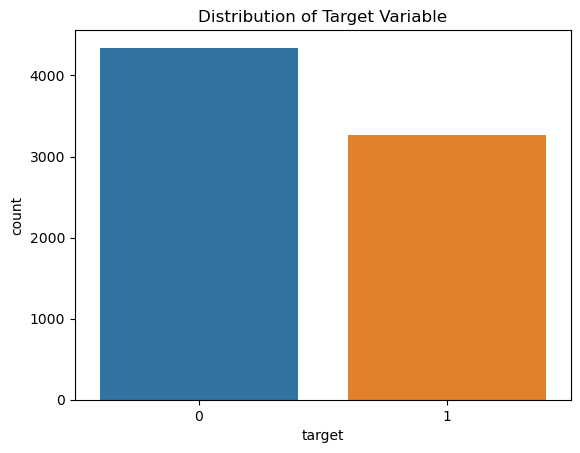

In [19]:
sns.countplot(x='target', data=df_train)
plt.title('Distribution of Target Variable')
plt.show()

# Preprocess the data

In [20]:
# Feature Engineering: Adding length of the tweet as a feature
df_train['text_length'] = df_train['text'].apply(len)
df_test['text_length'] = df_test['text'].apply(len)

# Feature Engineering: Adding number of words in the tweet as a feature
df_train['word_count'] = df_train['text'].apply(lambda x: len(x.split()))
df_test['word_count'] = df_test['text'].apply(lambda x: len(x.split()))

# Feature Engineering: Adding a feature to check for the presence of keywords
keywords = ['disaster', 'emergency', 'help', 'fire', 'flood', 'earthquake']

for keyword in keywords:
    df_train[f'keyword_{keyword}'] = df_train['text'].apply(lambda x: 1 if keyword in x.lower() else 0)
    df_test[f'keyword_{keyword}'] = df_test['text'].apply(lambda x: 1 if keyword in x.lower() else 0)

print(df_train.head())


   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  text_length  word_count  keyword_disaster  keyword_emergency  \
0       1           69          13                 0                  0   
1       1           38           7                 0                  0   
2       1          133          22                 0                  0   
3       1           65           8                 0                  0   
4       1           88          16                 0                  0   

   keyword_help  keyword_fire  keyword_flood  keyword_earthquake  
0             0    

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


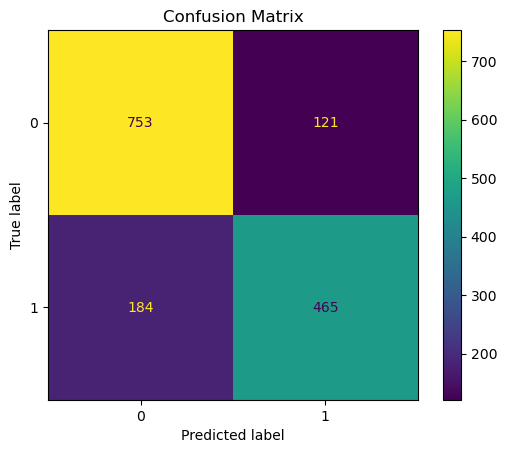

Accuracy: 79.97%


In [21]:
preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(), 'text'),
        ('num', StandardScaler(), ['text_length', 'word_count'] + [f'keyword_{keyword}' for keyword in keywords])
    ])

# Define the full pipeline including the preprocessor and the classifier
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', LogisticRegression())
])

# Train the model
pipeline.fit(X_train, y_train)

# Validate the model
y_pred = pipeline.predict(X_val)

# Evaluate the model
conf_mat = confusion_matrix(y_val, y_pred)
ConfusionMatrixDisplay(conf_mat).plot()
plt.title('Confusion Matrix')
plt.show()

print('Accuracy: {:.2f}%'.format(100 * (y_pred == y_val).mean()))


              precision    recall  f1-score   support

           0       0.80      0.86      0.83       874
           1       0.79      0.72      0.75       649

    accuracy                           0.80      1523
   macro avg       0.80      0.79      0.79      1523
weighted avg       0.80      0.80      0.80      1523



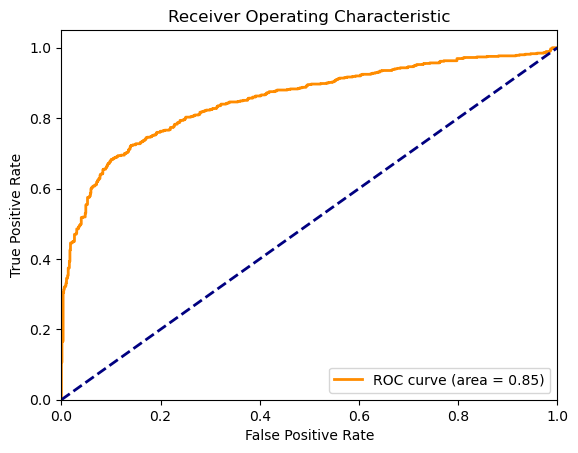

In [22]:
print(classification_report(y_val, y_pred))

# ROC Curve
y_pred_proba = pipeline.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [28]:
# Predicting the target for the test dataset
test_predictions = pipeline.predict(df_test)

# Creating a DataFrame for the submission file
submission_df = pd.DataFrame({
    'id': df_test['id'],
    'target': test_predictions
})

# Saving the DataFrame to a CSV file
submission_df.to_csv('submission.csv', index=False)


The logistic regression model for classifying disaster-related tweets achieved an overall accuracy of 80%. When breaking down the performance metrics, we see that the model excels at identifying non-disaster tweets, with a precision of 80% and a recall of 86%. This means that 80% of the tweets predicted as non-disasters were correct, and the model successfully identified 86% of actual non-disaster tweets, resulting in a solid F1-score of 0.83.

For disaster tweets, the model's precision is 79%, indicating that 79% of the tweets it predicted as disasters were accurate. However, the recall for disaster tweets is slightly lower at 72%, meaning the model correctly identified 72% of actual disaster tweets. This lower recall brings the F1-score for disaster tweets to 0.75, suggesting that while the model is fairly good at predicting disasters, it does miss some.

Overall, the model performs consistently well across both classes, with a weighted average F1-score of 0.80, which matches its overall accuracy. This shows that the model is a reliable tool for distinguishing between disaster and non-disaster tweets. However, there is room for improvement, particularly in enhancing the model's ability to detect all disaster-related tweets. By further refining the model and incorporating additional features, we could potentially increase its recall for disaster tweets, making it even more effective in real-world scenarios.